In [1]:
import requests
from requests.auth import HTTPBasicAuth
import os
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime, timedelta
import re
import numpy as np
import math
import statsmodels.api as sm
import os

In [2]:
root_dir = os.path.join('..', '..')
data_dir = os.path.join(root_dir, 'data')
plt.style.use(os.path.join(root_dir, 'misc', 'stylesheets', 'cb.mplstyle'))

# Get data from API

In [3]:
def data_is_present():
    data_path = os.path.join(data_dir, 'vaccine_sentiment.csv')
    return os.path.isfile(data_path)

In [4]:
def read_data():
    if data_is_present():
        data_path = os.path.join(data_dir, 'vaccine_sentiment.csv')
        print('Reading data from {}'.format(data_path))
        return pd.read_csv(data_path, index_col='date', parse_dates=True)
    params = {'interval': 'hour', 'start_date': '2017-06-26 00:00:00', 'end_date': 'now'}
    for auth_env in ['API_USERNAME', 'API_PASSWORD']:
        if auth_env not in os.environ:
            raise Exception('Cannot use API without API_USERNAME and API_PASSWORD set as environment variables.')
    auth = HTTPBasicAuth(os.getenv('API_USERNAME'), os.getenv('API_PASSWORD'))
    neutral = requests.get("https://api.crowdbreaks.org/sentiment/data/neutral", params=params, auth=auth)
    pro_vaccine = requests.get("https://api.crowdbreaks.org/sentiment/data/pro-vaccine", params=params, auth=auth)
    anti_vaccine = requests.get("https://api.crowdbreaks.org/sentiment/data/anti-vaccine", params=params, auth=auth)
    assert neutral.ok and pro_vaccine.ok and anti_vaccine.ok
    raw_data = {'neutral': neutral, 'pro_vaccine': pro_vaccine, 'anti_vaccine': anti_vaccine}
    data = []
    for i, d in raw_data.items():
        data.append(pd.DataFrame(d.json()))
        data[-1].columns = [i, 'key', 'date']
    # merge everything on date column
    df_data = reduce(lambda left,right: pd.merge(left,right,on='date'), data)
    df_data = df_data.set_index(pd.DatetimeIndex(df_data['date']))
    df_data = df_data[['anti_vaccine', 'pro_vaccine', 'neutral']]
    df_data.rename(columns={'neutral': 'Neutral', 'pro_vaccine': 'Pro-vaccine', 'anti_vaccine': 'Anti-vaccine'}, inplace=True)
    # clean data 
    for col in df_data:
        # set null values to zero
        df_data.loc[df_data[col] != 'null', col].apply(float) 
        df_data.loc[df_data[col] == 'null', col] = np.nan
        df_data[col] = pd.to_numeric(df_data[col])
        
        # set first and last value surrounding data gap to nan (as they contain only partial data)
        for i, v in enumerate(df_data[col]):
            if i > 0 and i < len(df_data[col]) - 1:
                if np.isnan(v):
                    if not np.isnan(df_data[col][i-1]):
                        df_data.iloc[i-1,  df_data.columns.get_loc(col)] = np.nan
                    if not np.isnan(df_data[col][i+1]):
                        df_data.iloc[i+1, df_data.columns.get_loc(col)] = np.nan
        # interpolate the nan values
        df_data[col] = df_data[col].interpolate()
    return df_data

In [5]:
df = read_data()

Reading data from ../../data/vaccine_sentiment.csv


# Store data

In [6]:
if not data_is_present():
    print('Storing data...')
    f_path = os.path.join(data_dir, 'vaccine_sentiment.csv')
    df.to_csv(f_path, encoding='utf8')

# Params

In [7]:
start_date = datetime(2017, 6, 30)
end_date = datetime(2019, 2, 1)
area_smooth = 7
version = 1
savefig = True
plot_formats = ['png', 'eps', 'tiff']

# Sentiment vs time

Saving figure...


<Figure size 960x600 with 0 Axes>

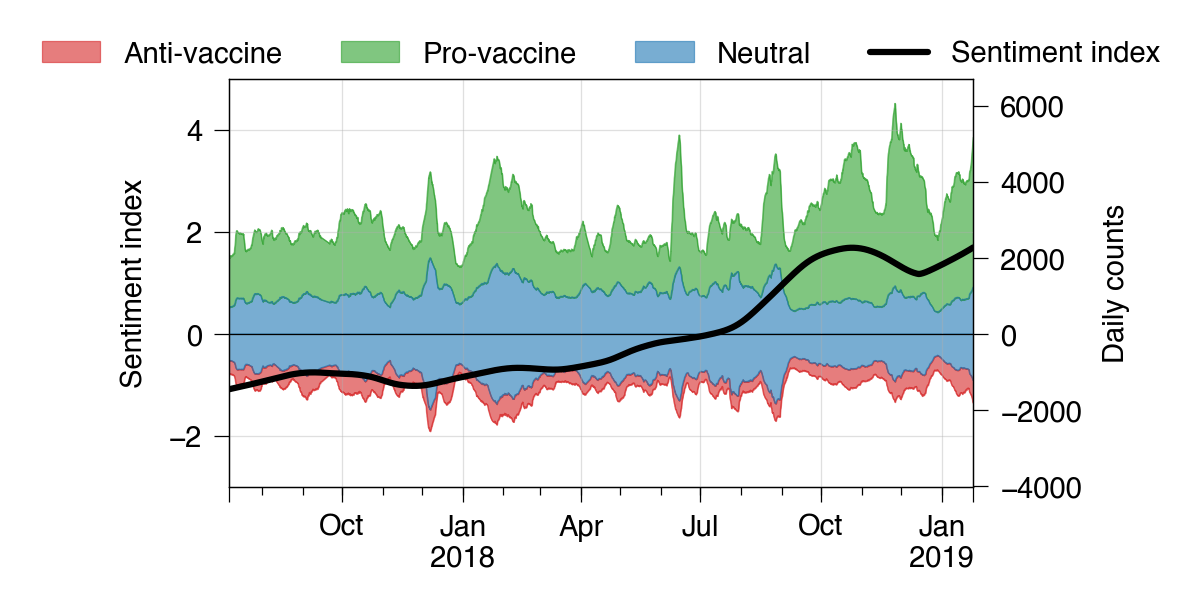

In [10]:
plt.clf()
fig, ax = plt.subplots()

df_binned = df.rolling(area_smooth*24).sum()[start_date:end_date]
df_binned /= float(area_smooth)

# neutral pos/negative
df_binned['Neutral-pos'] = df_binned['Neutral'] / 2
df_binned['Neutral-neg'] = - df_binned['Neutral'] / 2
df_binned['Anti-vaccine'] = -1 * df_binned['Anti-vaccine']

# calculate lowess
lowess = sm.nonparametric.lowess
ratio = df['Pro-vaccine'] / df['Anti-vaccine']
ratio_lowess = lowess(ratio.values, df.index, frac=0.2)
ratio_lowess = pd.Series(ratio_lowess[:, 1], index=df.index)
mean = ratio_lowess.mean()
std = ratio_lowess.std()
ratio_lowess -= mean
ratio_lowess /= std

# colors
plot_cols = ['Neutral-pos', 'Neutral-neg', 'Pro-vaccine', 'Anti-vaccine']
color_dict = {'Neutral': 'C0', 'Pro-vaccine': 'C2', 'Anti-vaccine': 'C3'}
colors = [color_dict.get(c, 'C0') for c in plot_cols]

# plotting
ratio_lowess.plot(ax=ax, kind='line', c='k', lw=1.5)
ax2 = ax.twinx()
df_binned[plot_cols].plot(ax=ax2, kind='area', stacked=True, color=colors, lw=0.3, alpha=.6)
ax.axhline(0, color='black', lw=0.3)

ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

# axis section
y_shift = .6
ax.set_ylim([-5*y_shift, 5])
max_counts = max([abs(i) for i in ax2.get_ylim()]) * 0.8
ax2.set_ylim([-max_counts*y_shift, max_counts])
ax2.set_ylim([-max_counts*y_shift, max_counts])

ax2.set_xlim([start_date+timedelta(days=area_smooth), end_date-timedelta(days=area_smooth)])
ax2.set_ylabel('Daily counts')
ax.set_ylabel('Sentiment index')

# changes to plot layout
ax2.xaxis.set_visible(False)
ax.xaxis.label.set_visible(False)
ax.grid()

# legend
ax2.legend_.remove()
handles, labels = ax2.get_legend_handles_labels()
_handles, _labels = ax.get_legend_handles_labels()
new_handles = []
new_labels = []
legend_labels = ['Anti-vaccine', 'Pro-vaccine']
for l in legend_labels:
    if l in labels:
        new_labels.append(l)
        new_handles.append(handles[labels.index(l)])
try:
    new_handles.append(handles[labels.index('Neutral-pos')])
    new_labels.append('Neutral')
except ValueError:
    pass
new_handles.extend(_handles)
new_labels.extend(['Sentiment index'])
plt.legend(new_handles, new_labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), frameon=False, ncol=5)

# save fig
if savefig:
    print('Saving figure...')
    folder_path = os.path.join('.', 'v{}'.format(version))
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)
    def f_name(fmt):
        f_name = 'fig4.{}'.format(fmt)
        return os.path.join(folder_path, f_name)   
    for fmt in plot_formats:
        if not fmt == 'tiff':
            plt.gcf().savefig(f_name(fmt), bbox_inches='tight')
    if 'tiff' in plot_formats:
        os.system("convert {} {}".format(f_name('png'), f_name('tiff')))